# Part VIII: Numerical methods

Line searches with backtracking generalize immediately from $\mathbb{R}^2$ to $\mathbb{R}^d$, as do gradient descent increments,

$$
\Delta x^{(k)} = -\nabla f({\bf x}^{(k)}),
$$

and Newton's step directions

$$
\Delta x^{(k)} = -\left(\nabla^2 f({\bf x}^{(k)})\right)^{-1}\nabla f({\bf x}^{(k)}).
$$

Convergence rates for function values, linear convergence of gradient descent, and quadratic convergence of Newton's method can also be generalized for particular classes of functions.

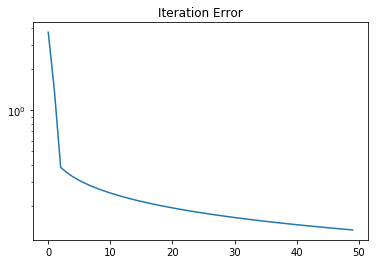

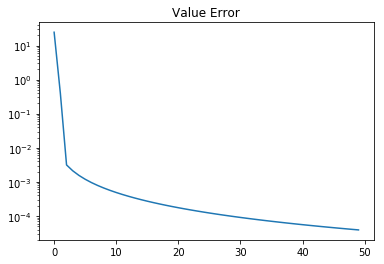

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def backtracking(x0, dx, f, df0, alpha=0.2, beta=0.8, verbose=False):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * np.sum(dx * df0) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(x0) # Evaluate for future use
    x = x0 + dx # Initialize x_{0, inner}
    fx = f(x)
    
    if verbose:
        n=0
        xs = [x]
        fs = [fx]
        ts = [1] * 3
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        x = x0 + t * dx
        fx = f(x)
    ###################################### 
    
        if verbose:
            n += 1
            xs.append(x)
            fs.append(fx)
            ts.append(t)
            ts.pop(0)
            
    if verbose:
        # Display the function along the line search direction as a function of t
        s = np.linspace(-0.1*ts[-1], 1.1*ts[0], 100)
        xi = [0, 1.1*ts[0]]
        fxi = [f0, f0 + 1.1*ts[0]*delta]   
        y = np.zeros(len(s))
        
        for i in range(len(s)):
            y[i] = f(x0 + s[i]*dx) # Slow for vectorized functions

        plt.figure('Backtracking illustration')
        arm, =plt.plot(xi, fxi, '--', label='Armijo Criterion')
        fcn, =plt.plot(s, y, label='Objective Function')
        plt.plot([s[0], s[-1]], [0, 0], 'k--')
        pts =plt.scatter(ts, [0 for p in ts], label='Backtracking points for n=%d, %d, %d' % (n, n+1, n+2))
        plt.scatter(ts, [f(x0 + q*dx) for q in ts] , label='Backtracking values for n=%d, %d, %d' % (n, n+1, n+2))
        init =plt.scatter([0], [f0], color='black', label='Initial point')
        plt.xlabel('$t$')
        plt.ylabel('$f(x^{(k)}+t\Delta x^{(k+1)})$')
        plt.legend(handles=[arm, fcn, pts, init])
        plt.show()
        
        return x, xs, fs
    
    else:
        return x
    
fun = lambda x: np.sum(x**4)/4
dfun = lambda x: x**3
d2fun = lambda x: 3*np.diag(x**2)

x0 = np.array([2, 1, -3])
dx = -dfun(x0)

alpha = 0.1
beta = 0.5

num_iter = 50

x = np.zeros((3, num_iter))
errs = np.zeros(num_iter)
fvals = np.zeros(num_iter)

x[:,0] = x0
errs[0] = np.sqrt(np.sum(x[:,0]**2))
fvals[0] = fun(x[:,0])

for i in range(1,num_iter):
    x[:,i] = backtracking(x[:,i-1], -dfun(x[:,i-1]), fun, dfun(x[:,i-1]), alpha=alpha, beta=beta)
    errs[i] = np.sqrt(np.sum(x[:,i]**2))
    fvals[i] = fun(x[:,i])
    
plt.semilogy(errs)
plt.title('Iteration Error')
plt.show()

plt.semilogy(fvals)
plt.title('Value Error')
plt.show()


## Log barrier method

For general constrained optimization methods, we can use the log barrier method to numerically solve inequality constrained programs

$$
\min f({\bf x})\text{ subject to } h_1({\bf x})\leq 0,\ldots, h_m({\bf x})\leq 0
$$

by successively solving the sequence of programs

$$
\min f({\bf x}) - \frac{1}{t}\sum_{j=1}^m\log(-h_j({\bf x})).
$$

for $t\rightarrow\infty$. In addition, if the program 

$$
\min f({\bf x})\text{ subject to } g_1({\bf x})=0, \ldots, g_n({\bf x})=0, h_1({\bf x})\leq 0,\ldots, h_m({\bf x})\leq 0
$$

is convex, then the sequence of log-barrier programs

$$
\min f({\bf x}) - \frac{1}{t}\sum_{j=1}^m\log(-h_j({\bf x})) \text{ subject to } g_1({\bf x})=0, \ldots, g_n({\bf x})=0
$$

are also convex.

Now, in 1D and 2D, it was easy to find a *strictly feasible* $x^{(0)}$ to perform the first centering step. In $\mathbb{R}^d$, it is not at all clear how to find such an $x^{(0)}$. Thus, a general **interior point method** is split into two phases:

1. (**Phase I**) Find ${\bf x}^{(0)}$ such that $g_i({\bf x}^{(0)})=0$ and $h_j({\bf x}^{(0)})<0$ for all $i=1,\ldots, n$ and all $j=1,\ldots, m$
2. (**Phase II**) Perform the centering step, and the outer/inner loops of the log barrier method

Any algorithm which produces an interior point will be called a Phase I method. For the inequality constrained program

$$
\min f({\bf x})\text{ subject to } h_1({\bf x})\leq 0,\ldots, h_m({\bf x})\leq 0.
$$

we can find an interior point (if one exists) by introducing a parameter $z\in\mathbb{R}$ solving the augmented program

$$
\min_{({\bf x}, z)} z \text{ subject to }h_1({\bf x})\leq z,\ldots, h_m({\bf x})\leq z.
$$

The log barrier method can be used to solve this program, and a clever trick allows us to easily produce an initial ${\bf x}^{(0)}$ and $z^{(0)}$ to begin the centering step. 

1. Choose any ${\bf x}^{(0)}\in\mathbb{R}^d$.
2. Set $z^{(0)}=\max(h_1({\bf x}^{(0)}),\ldots,h_m({\bf x}^{(0)}))+1$

Note that this ensures that $h_j({\bf x}^{(0)})-z^{(0)}<0$ for all $j=1,\ldots, m$. Moreover, if the log barrier method yields a $z^{(k)}<0$, we can be certain that the original program is strictly feasible and the corresponding ${\bf x}^{(k)}$ is an interior point.


/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in log


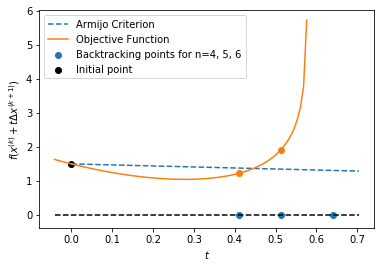

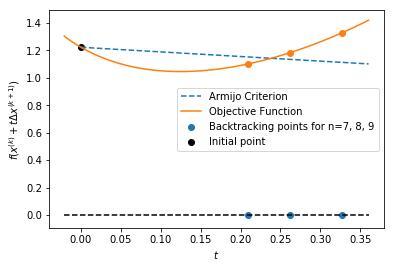

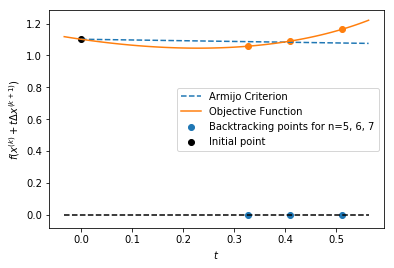

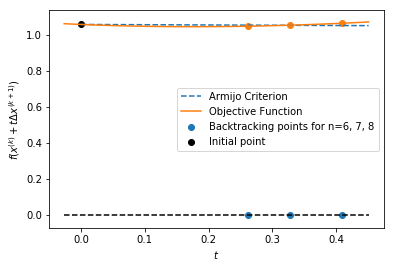

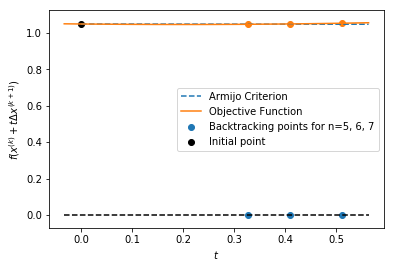

/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in log


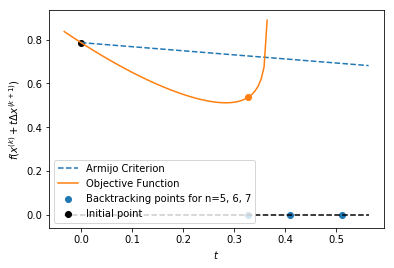

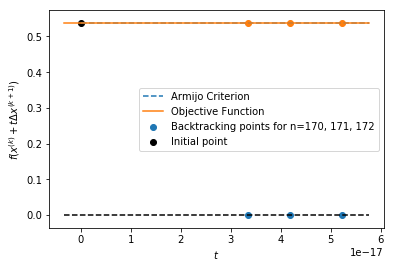

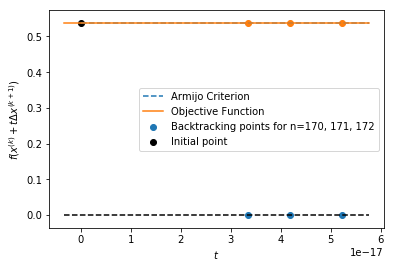

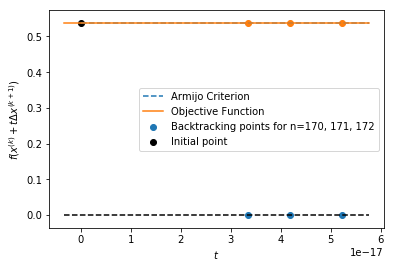

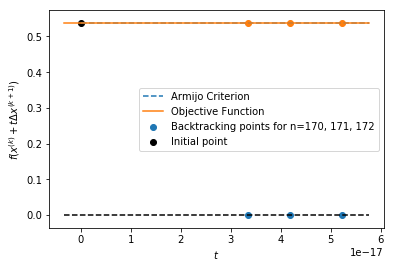

/Users/n8/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:106: RuntimeWarning: invalid value encountered in log


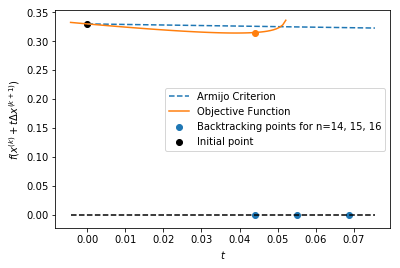

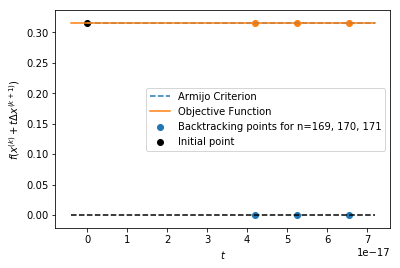

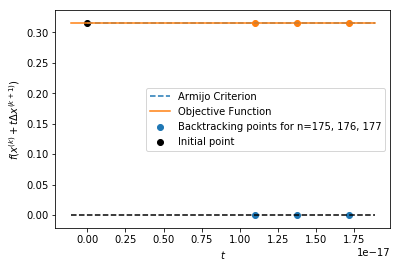

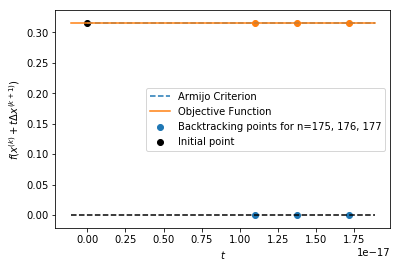

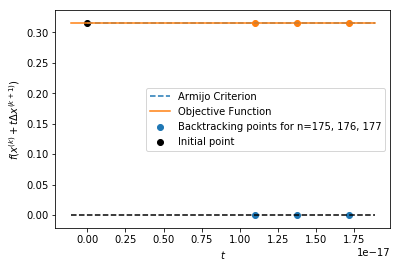

[[ 0.01        0.40731036  0.18764097  0.31636054  0.25853377  0.28956907]
 [-0.01        0.41188964  0.1873928   0.31637551  0.25853359  0.2895691 ]
 [ 0.          0.4096      0.18751688  0.31636802  0.25853368  0.28956909]]
[[ 0.28956907  0.54771844  0.54771844  0.54771844  0.54771844  0.54771844]
 [ 0.2895691   0.54771846  0.54771846  0.54771846  0.54771846  0.54771846]
 [ 0.28956909  0.54771845  0.54771845  0.54771845  0.54771845  0.54771845]]
[[ 0.54771844  0.57242712  0.57242712  0.57242712  0.57242712  0.57242712]
 [ 0.54771846  0.57242714  0.57242714  0.57242714  0.57242714  0.57242714]
 [ 0.54771845  0.57242713  0.57242713  0.57242713  0.57242713  0.57242713]]


In [75]:
import numpy as np
import matplotlib.pyplot as plt

def backtracking(x0, dx, f, df0, alpha=0.2, beta=0.8, verbose=False):
    '''
    Backtracking for general functions with illustrations
    :param x0: Previous point from backtracking, or initial guess
    :param dx: Incremental factor for updating x0
    :param f: Objective function
    :param df0: Gradient of f at x0
    :param alpha: Sloping factor of stopping criterion
    :param beta: "Agressiveness" parameter for backtracking steps
    :param verbose: Boolean for providing plots and data
    :return: x1, the next iterate in backtracking
    '''

    # Note that the definition below requires that dx and df0 have the same shape
    delta = alpha * np.sum(dx * df0) # A general, but memory intensive inner product
    
    t = 1 # Initialize t=beta^0
    f0 = f(x0) # Evaluate for future use
    x = x0 + dx # Initialize x_{0, inner}
    fx = f(x)
    
    if verbose:
        n=0
        xs = [x]
        fs = [fx]
        ts = [1] * 3
    
    while (not np.isfinite(fx)) or f0 + delta * t < fx:
        t = beta * t
        x = x0 + t * dx
        fx = f(x)
    ###################################### 
    
        if verbose:
            n += 1
            xs.append(x)
            fs.append(fx)
            ts.append(t)
            ts.pop(0)
            
    if verbose:
        # Display the function along the line search direction as a function of t
        s = np.linspace(-0.1*ts[-1], 1.1*ts[0], 100)
        xi = [0, 1.1*ts[0]]
        fxi = [f0, f0 + 1.1*ts[0]*delta]   
        y = np.zeros(len(s))
        
        for i in range(len(s)):
            y[i] = f(x0 + s[i]*dx) # Slow for vectorized functions

        plt.figure('Backtracking illustration')
        arm, =plt.plot(xi, fxi, '--', label='Armijo Criterion')
        fcn, =plt.plot(s, y, label='Objective Function')
        plt.plot([s[0], s[-1]], [0, 0], 'k--')
        pts =plt.scatter(ts, [0 for p in ts], label='Backtracking points for n=%d, %d, %d' % (n, n+1, n+2))
        plt.scatter(ts, [f(x0 + q*dx) for q in ts] , label='Backtracking values for n=%d, %d, %d' % (n, n+1, n+2))
        init =plt.scatter([0], [f0], color='black', label='Initial point')
        plt.xlabel('$t$')
        plt.ylabel('$f(x^{(k)}+t\Delta x^{(k+1)})$')
        plt.legend(handles=[arm, fcn, pts, init])
        plt.show()
        
        return x, xs, fs
    
    else:
        return x

# Two steps of the log barrier method

fun = lambda x: np.sum((x-1)**2)/2
dfun = lambda x: x-1

h = lambda x: np.sum(x*x)-1
dh = lambda x: 2*x

lb1 = lambda x: fun(x) - np.log(-h(x))
dlb1 = lambda x: dfun(x) - dh(x)/h(x)

alpha = 0.1
beta = 0.8

x1 = np.zeros((3, 6))
x1[:,0] = np.array([0.01, -0.01, 0.0])

x1[:, 1], xs, fs = backtracking(x1[:,0], -dlb1(x1[:,0]), lb1, dlb1(x1[:,0]), alpha=alpha, beta=beta, verbose=True)
x1[:, 2], xs, fs = backtracking(x1[:, 1], -dlb1(x1[:,1]), lb1, dlb1(x1[:,1]), alpha=alpha, beta=beta, verbose=True)
x1[:, 3], xs, fs = backtracking(x1[:, 2], -dlb1(x1[:,2]), lb1, dlb1(x1[:,2]), alpha=alpha, beta=beta, verbose=True)
x1[:, 4], xs, fs = backtracking(x1[:, 3], -dlb1(x1[:,3]), lb1, dlb1(x1[:,3]), alpha=alpha, beta=beta, verbose=True)
x1[:, 5], xs, fs = backtracking(x1[:, 4], -dlb1(x1[:,4]), lb1, dlb1(x1[:,4]), alpha=alpha, beta=beta, verbose=True)

lb2 = lambda x: fun(x) - 0.1*np.log(-h(x))
dlb2 = lambda x: dfun(x) + 0.1*dh(x)/h(x)

x2 = np.zeros((3, 6))
x2[:,0] = x1[:, 5] # initialize at the output of previous step

x2[:, 1], xs, fs = backtracking(x2[:,0], -dlb2(x2[:,0]), lb2, dlb2(x2[:,0]), alpha=alpha, beta=beta, verbose=True)
x2[:, 2], xs, fs = backtracking(x2[:, 1], -dlb2(x2[:,1]), lb2, dlb2(x2[:,1]), alpha=alpha, beta=beta, verbose=True)
x2[:, 3], xs, fs = backtracking(x2[:, 2], -dlb2(x2[:,2]), lb2, dlb2(x2[:,2]), alpha=alpha, beta=beta, verbose=True)
x2[:, 4], xs, fs = backtracking(x2[:, 3], -dlb2(x2[:,3]), lb2, dlb2(x2[:,3]), alpha=alpha, beta=beta, verbose=True)
x2[:, 5], xs, fs = backtracking(x2[:, 4], -dlb2(x2[:,4]), lb2, dlb2(x2[:,4]), alpha=alpha, beta=beta, verbose=True)

lb3 = lambda x: fun(x) - 0.01*np.log(-h(x))
dlb3 = lambda x: dfun(x) + 0.01*dh(x)/h(x)

x3 = np.zeros((3, 6))
x3[:,0] = x2[:, 5] # initialize at the output of previous step

x3[:, 1], xs, fs = backtracking(x3[:, 0], -dlb3(x3[:,0]), lb3, dlb3(x3[:,0]), alpha=alpha, beta=beta, verbose=True)
x3[:, 2], xs, fs = backtracking(x3[:, 1], -dlb3(x3[:,1]), lb3, dlb3(x3[:,1]), alpha=alpha, beta=beta, verbose=True)
x3[:, 3], xs, fs = backtracking(x3[:, 2], -dlb3(x3[:,2]), lb3, dlb2(x3[:,2]), alpha=alpha, beta=beta, verbose=True)
x3[:, 4], xs, fs = backtracking(x3[:, 3], -dlb3(x3[:,3]), lb3, dlb2(x3[:,3]), alpha=alpha, beta=beta, verbose=True)
x3[:, 5], xs, fs = backtracking(x3[:, 4], -dlb3(x3[:,4]), lb3, dlb2(x3[:,4]), alpha=alpha, beta=beta, verbose=True)

print(x1)
print(x2)
print(x3)

## Primal-Dual Methods

Another common class of methods attempts to approximately solve the KKT condtions. Suppose we have an inequality constrained program

$$
\min f({\bf x})\text{ subject to } h_1({\bf x})\leq 0,\ldots, h_m({\bf x})\leq 0
$$

As $t\rightarrow\infty$, we find solutions $({\bf x}^{(t)}, \mu^{(t)})$ that solve the approximate KKT conditions

1. $\nabla f({\bf x}) + D h({\bf x})^T \mu ={\bf 0}$
2. $h({\bf x}) < {\bf 0}$
3. $\mu > {\bf 0}$
4. $-\mu\cdot h({\bf x})=\frac{1}{t}{\bf 1}$

Recalling that Newton's method seeks solutions to systems of equations, we consider Newton directions for the function $\varphi:\mathbb{R}^d\times\mathbb{R}^m\rightarrow \mathbb{R}^d\times\mathbb{R}^m$ defined by

$$
\varphi\begin{pmatrix} {\bf x}\\ \mu\end{pmatrix} = \begin{pmatrix}\nabla f({\bf x}) + Dh({\bf x})^T\mu\\ -\left(\mu\cdot h({\bf x})+\frac{1}{t}{\bf 1}\right)\end{pmatrix}.
$$

The Jacobian of this map has the block form

$$
\begin{pmatrix}
\nabla^2 f({\bf x}) + \sum_{j=1}^m\mu_j \nabla^2 h_j({\bf x}) & Dh({\bf x})^T\\
-\text{diag}(\mu)Dh({\bf x}) & -\text{diag}(h({\bf x}))
\end{pmatrix}
$$

Instead of Newton iterations, however, we perform a line search to solve

$$
\min_{s > 0} \left\Vert\varphi\left(\begin{pmatrix} {\bf x}^{(k)}\\ \mu^{(k)}\end{pmatrix} + s \Delta {\bf x}^{(k)}\right)\right\Vert^2
$$

where 

$$
\Delta{\bf x}^{(k)}= - \begin{pmatrix}
\nabla^2 f({\bf x}^{(k)}) + \sum_{j=1}^m\mu_j^{(k)} \nabla^2 h_j({\bf x}^{(k)}) & Dh({\bf x}^{(k)})^T\\
-\text{diag}(\mu^{(k)})Dh({\bf x}^{(k)}) & -\text{diag}(h({\bf x}^{(k)}))
\end{pmatrix}^{-1} \begin{pmatrix}\nabla f({\bf x}^{(k)}) + Dh({\bf x}^{(k)})^T\mu^{(k)}\\ -\left(\mu^{(k)}\cdot h({\bf x}^{(k)})-\frac{1}{t}{\bf 1}\right)\end{pmatrix}
$$

is the Newton search direction.

Fix $\nu>1$ ($\nu=10$ is fine). One substantial difference between the barrier method and the primal-dual algorithm is that there is no inner/outer loop, and $t$ updates after every backtracking step. In particular,

$$
t^{(k+1)} = \nu m / (-h({\bf x}^{(k)})^T \mu^{(k)}),
$$

where $\eta(\mu,{\bf x}) = -h({\bf x})^T\mu$ is called the **surrogate duality gap**. We will discuss duality gaps later.

Now, using $s$ as our backtracking parameter, our stopping criterion will be to find $s=\beta^n$ such that

$$
\left\Vert\varphi\left(\begin{pmatrix} {\bf x}^{(k)}\\ \mu^{(k)}\end{pmatrix} + s \Delta{\bf x}^{(k)}\right)\right\Vert\leq (1-\alpha s)\left\Vert\varphi\begin{pmatrix} {\bf x}^{(k)}\\ \mu^{(k)}\end{pmatrix}\right\Vert
$$

### Example

Consider minimizing $f({\bf x})=\Vert {\bf x}-{\bf 1}\Vert^2$ subject to $h({\bf x})=\Vert {\bf x}\Vert^2 -1\leq 0$. Then $\varphi:\mathbb{R}^2\times \mathbb{R}^1\rightarrow\mathbb{R}^2\times \mathbb{R}^1$ is given by

$$
\varphi\begin{pmatrix} x_1\\ x_2\\ \mu\end{pmatrix} = \begin{pmatrix} 2x_1-2+2\mu x_1\\ 2x_2-2+2\mu x_2\\ -\mu(x_1^2+x_2^2-1) -\frac{1}{t}\end{pmatrix} 
$$

with

$$
D\varphi\begin{pmatrix} x_1\\ x_2\\ \mu\end{pmatrix} = \begin{pmatrix}
2 + 2\mu & 0 & 2x_1\\
0 & 2 + 2\mu & 2x_2\\
-2\mu x_1 & -2\mu x_2 & 1-x_1^2-x_2^2
\end{pmatrix}.
$$

Our surrogate duality gap function is $\eta(\mu, {\bf x}) = \mu(1-\Vert {\bf x}\Vert^2)$.

[[ 10.]]
2.96816441593


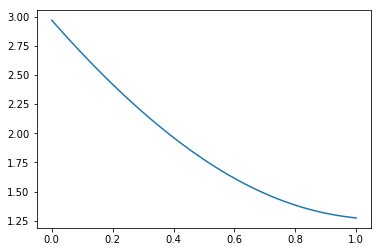

[[ 200.]]
1.27358745283


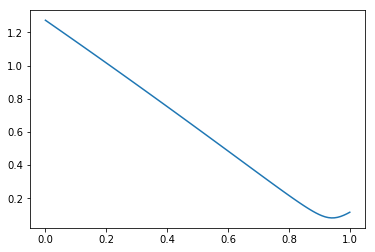

[[ 1631.35059326]]
0.61964465917


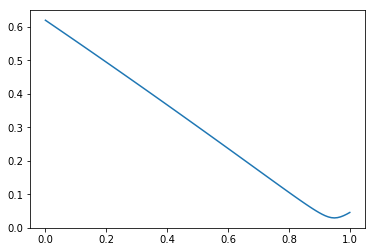

[[ 3613.31423381]]
0.462743344941


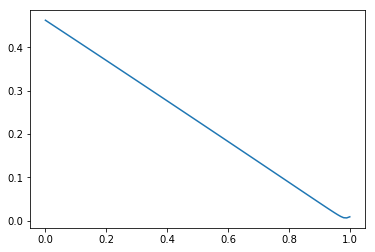

[[ 5722.08426499]]
0.346659271819


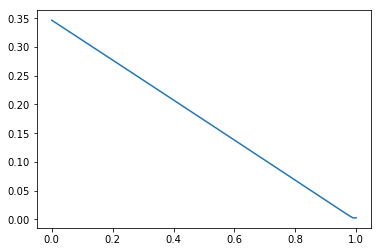

[[ 20454.30188484]]
0.172857059088


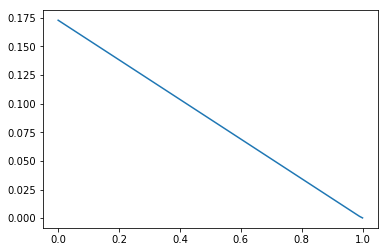

[[ 43097.50051625]]
0.0863916836025


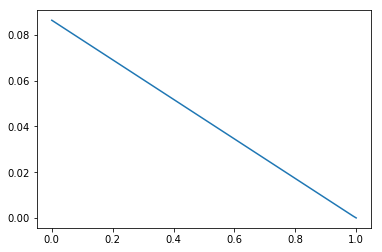

[[ 82763.26775696]]
0.0431890692044


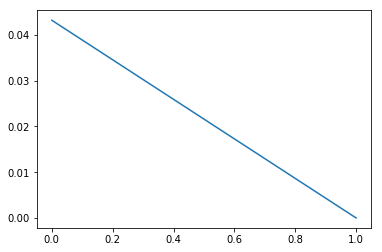

[[ 1726129.52556983]]
8.16341596634e-06


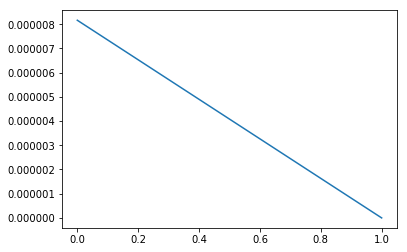

[[ 17257269.2381397]]
5.21519381535e-07


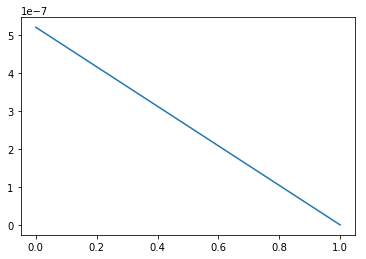

Numerical solution after 10 steps:
[[ 0.70710673]
 [ 0.70710673]]
[[ 0.41421366]]
Actual solution:
[ 0.70710678  0.70710678]
0.414213562373


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def l2(x):
    return np.sqrt(np.sum(x**2))

f = lambda x: np.reshape(np.sum((x-1)**2), (1, 1)) # Reshape coerces dimension for block
df = lambda x: 2*(x-1)
d2f = lambda x: 2*np.eye(2)

h = lambda x: np.reshape(np.sum(x**2)-1, (1, 1))
dh = lambda x: 2*x
d2h = lambda x: 2*np.eye(2)

phi = lambda x, mu, t:  np.concatenate((df(x)+mu*dh(x),-mu*h(x)-1/t))
dphi = lambda x, mu: np.reshape(np.block([[d2f(x) + mu*d2h(x), dh(x)], [-np.diag(mu)@dh(x).T, -np.array([h(x)])]]), (d+m, d+m)) 
# block is new in numpy 1.13.0

def diagnostic(d, x, mu, t, dx_mu):
    n = 100
    s = np.linspace(0, 1.0, n)
    vals = np.zeros(n)
    for i in range(n):
        vals[i] = l2(phi(x + s[i]*dx_mu[:d], mu + s[i]*dx_mu[d:], t))
        
    plt.plot(s, vals)
    plt.show()
    

num_iter = 10
d = 2 # dimension of the program
m = 1 # number of inequality constraints
x0 = 0.0*np.ones((2,1)) # initial values for x_1, x_2 -- dimension is coerced to ensure column vector format
mu0 = -1/h(x0) # initial value for mu


nu = 10 # Interior point scaling parameter

# Backtracking parameters
alpha = 0.1
beta = 0.5

eta = lambda x, mu: -h(x)*mu # Computation of surrogate duality gap

x = x0
mu = mu0
for i in range(num_iter):
    t = nu * m / eta(x, mu)
    phi0 = phi(x,mu,t)
    norm_phi0 = l2(phi0)
    print(t)
    print(norm_phi0)
    
    # Compute the Newton search direction

    dx_mu = np.linalg.solve(dphi(x, mu), -phi0)
    
    # Initialize backtracking
    s = 1 # using s for backtracking parameter since t is taken
    yx = x + s*dx_mu[:d]
    ymu = mu + s*dx_mu[d:]
    hyx = h(yx)
    phiy = phi(yx, ymu, t)
    norm_phiy = l2(phiy)
    
    diagnostic(d, x, mu, t, dx_mu)
    
    while 0 < ymu[ymu<=0].size or 0 < hyx[0<=hyx].size or (1-alpha*s)*norm_phi0 < norm_phiy:
        s = beta * s
        yx = x + s*dx_mu[:d]
        ymu = mu + s*dx_mu[d:]
        hyx = h(yx)
        phiy = phi(yx, ymu, t)
        norm_phiy = l2(phiy)
        
    x = yx
    mu = ymu
    
print('Numerical solution after %d steps:' % num_iter)
print(x)
print(mu)

print('Actual solution:')
print(np.ones(2)/np.sqrt(2))
print(np.sqrt(2)-1)
    
    




## Group Problems

Write down the primal-dual steps and surrogate duality gaps for

1. $\min x+y+z\text{ subject to } x^2+y^2+z^2=1\text{ and } 3x+2y+z = 1$
2. $\min x+y+z\text{ subject to } 3x^2 + 2y^2 + z^2=1\text{ and }x\geq 0, y\geq0,z\geq 0$
3. $\min 3x+2y+z\text{ subject to } xyz=1\text{ and } x\geq0, y\geq 0, z\geq 0$
4. $\min 3x+2y+z\text{ subject to } x+y+z=1\text{ and }x\geq -1, y\geq -1, z\geq -1$
5. $\min x^2 + y^2 + z^2\text{ subject to } (x-3)^2\leq 1, (y-4)^2\leq 1, (z-5)^2\leq 1$
6. $\min x^2 + y^2 + z^2\text{ subject to } x+y+z=1\text{ and } 3x^2+2y^2+z^2\geq 1$
7. $\min 3x^2 + 2y^2 + z^2\text{ subject to } x^2+y^2+z^2=1\text{ and } x^2-2y^2+z^2\leq 0$
8. $\min 3x^2 + 2y^2 + z^2\text{ subject to } xyz=1\text{ and }x^2+y^2+z^2\leq 4$
